In [2]:
import pandas as pd
import numpy as np
import gwaslab as gl
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/clu/git/3D_cardiac_GWAS/src')
from bullseye import bullseye_plot, get_cmap_center
import matplotlib as mpl

In [11]:
locus_all = pd.read_csv('spatial_loci_threshold_3e-9.csv')

# Read hits
#  hits_all.sort_values(['Spatial_Only', 'impact_level', 'trait', 'GenomicLocus', 'IMPACT', 'MLOG10P'])[[
#     'Spatial_Only', 'impact_level', 'trait', 'GenomicLocus', 'gene_symbol_new', 'SNPID', 'IMPACT', 'most_severe_consequence', 'BETA', 'MLOG10P', 'EAF'
# ]].to_csv('exomeGWAS_hits.csv', index=False)
hits_all = pd.read_csv('exomeGWAS_hits.csv')
hits_all_transcript_vep = pd.read_csv('exomeGWAS_hits_transcript_vep.csv')

# Exome GWAS VEP

In [16]:
consequences = pd.read_csv('ensembl_consequence.list', sep='\t')
which_variants_tested_vep = which_variants_tested[['variant', 'most_severe_consequence', 'gene_symbol']].merge(consequences, left_on='most_severe_consequence', right_on='consequence_term', how='left').drop('consequence_term', axis=1)
which_variants_tested_vep.to_csv('which_variants_tested_vep.csv', index=False)

In [22]:
# save which_variants_tested
which_variants_tested = which_variants_tested.merge(which_variants_tested_vep, on='variant', how='left')
which_variants_tested.to_csv('exome_variants_tested_with_VEP.csv.gz', index=False, compression='gzip')

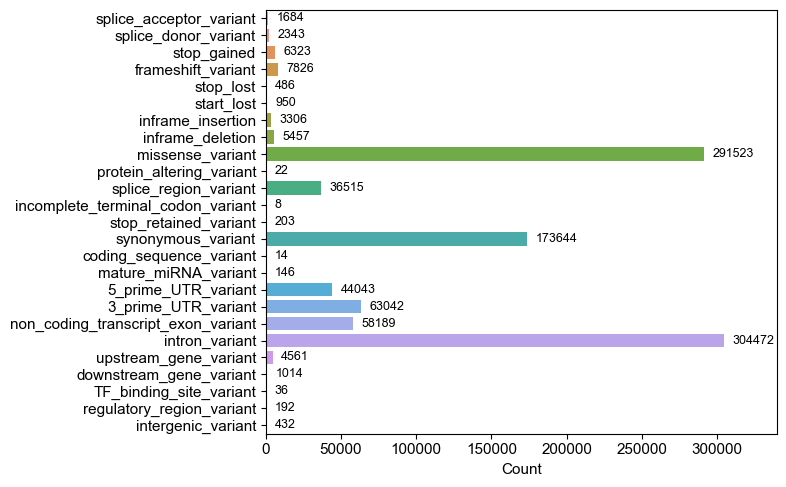

In [73]:
# plot the above type on y axis
fig, ax = plt.subplots(1,1,figsize=(8,5))
# font Arial
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams.update({'font.size': 11})
terms = set(which_variants_tested['most_severe_consequence'].unique())
term_order = [x for x in consequences['consequence_term'].tolist() if x in terms]
sns.countplot(data=which_variants_tested, y='most_severe_consequence', order=term_order, ax=ax)
# add count on the right
for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width() + 1000, p.get_y() + p.get_height() / 2), ha='left', va='center',
                fontsize=9, color='black', xytext=(5, 0), textcoords='offset points')
# x lim
ax.set_xlim(0, 340000)
ax.set_xlabel('Count')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/manhattan/exomeGWAS_most_severe_consequence_distribution.pdf')

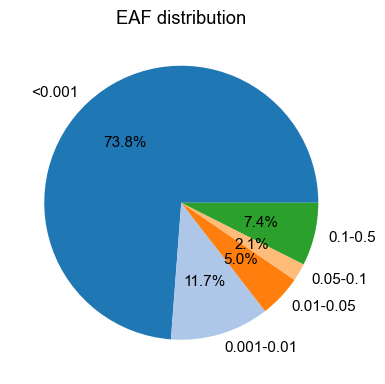

In [33]:
# new EAF where if EAF>0.5 then 1-EAF
which_variants_tested['EAF_new'] = np.where(which_variants_tested['EAF'] > 0.5, 1 - which_variants_tested['EAF'], which_variants_tested['EAF'])
# plot EAF distribution with pie chart, EAF<0.001, 0.001<=EAF<0.01, 0.01<=EAF<0.05, 0.05<=EAF<0.1, 0.1<=EAF<0.5
labels = ['<0.001', '0.001-0.01', '0.01-0.05', '0.05-0.1', '0.1-0.5']
which_variants_tested['EAF_bin'] = pd.cut(which_variants_tested['EAF_new'], bins=[0, 0.001, 0.01, 0.05, 0.1, 0.5], labels=labels)
fig, ax = plt.subplots(1,1,figsize=(4,4))
# font Arial
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams.update({'font.size': 11})
which_variants_tested['EAF_bin'].value_counts().loc[labels,].plot.pie(autopct='%1.1f%%', ax=ax, 
                                                         colors=sns.color_palette('tab20', n_colors=5), 
                                                            labels=labels)
ax.set_ylabel('')
# set title 
ax.set_title('EAF distribution')
plt.tight_layout()
# save
plt.savefig('/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/manhattan/exomeGWAS_EAF_distribution.pdf')

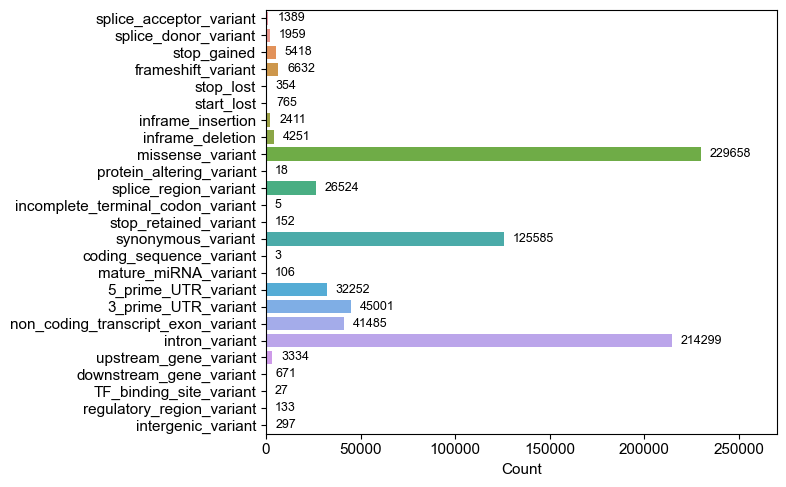

In [74]:
# most severe consequence distribution for EAF < 0.001
# plot
fig, ax = plt.subplots(1,1,figsize=(8,5))
# font Arial
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams.update({'font.size': 11})
terms = set(which_variants_tested['most_severe_consequence'].unique())
term_order = [x for x in consequences['consequence_term'].tolist() if x in terms]
sns.countplot(data=which_variants_tested[which_variants_tested['EAF_new'] < 0.001], y='most_severe_consequence', order=term_order, ax=ax)
# add count on the right
for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width() + 1000, p.get_y() + p.get_height() / 2), ha='left', va='center',
                fontsize=9, color='black', xytext=(5, 0), textcoords='offset points')
# x lim
ax.set_xlim(0, 270000)
ax.set_xlabel('Count')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/manhattan/exomeGWAS_most_severe_consequence_distribution_EAFless0.001.pdf')

## Manhattan plot

In [ ]:
def get_mysumstats(gwaspath):
    mysumstats = gl.Sumstats(gwaspath, fmt="regenie", verbose=False)
    # Exclude 90pct10dp failed variants
    mysumstats.data = mysumstats.data[~mysumstats.data['SNPID'].isin(excl_90pct10dp)]
    return mysumstats

exome_spatial_WT = get_mysumstats('/Volumes/acasis/cardiac/48K/exomeGWAS_aha_t64/AHA_exomeGWAS_{}_merged.SKIP2.regenie.gz'.format('WT'))
exome_spatial_Ecc = get_mysumstats('/Volumes/acasis/cardiac/48K/exomeGWAS_aha_t64/AHA_exomeGWAS_{}_merged.SKIP2.regenie.gz'.format('Ecc'))
exome_spatial_Ecc.data['BETA'] = -exome_spatial_Ecc.data['BETA']
exome_spatial_Err = get_mysumstats('/Volumes/acasis/cardiac/48K/exomeGWAS_aha_t64/AHA_exomeGWAS_{}_merged.SKIP2.regenie.gz'.format('Err'))

In [ ]:
# Read VEP annotations, just for the variants tested in the exome GWAS
vep_variants_tested = pd.read_csv('vep_variants_tested.csv')

In [8]:
# GET GWAS, hits, and annotate with gene_symbol, IMPACT, locusID, and plot manhattan: exome_spatial_WT, hits_WT, gene_impact_WT, locus_impact_WT
def get_hits(exome_spatial_WT, vep_variants_tested, p_threshold=5e-8/16):

    # WT hits by -log10(p) > 5e-8/16
    hits = exome_spatial_WT.data[exome_spatial_WT.data.MLOG10P>-np.log10(p_threshold)].sort_values(['CHR', 'POS']).reset_index(drop=True)
    hits['variant'] = 'chr' + hits['SNPID']
    hits = hits.merge(vep_variants_tested, on='variant', how='left')

    # remove gene_symbols containing '.' and number or ends with 'AS1' to a new column gene_symbol_new
    gene_symbol_new = []
    for gene_symbol in hits['gene_symbol']:
        try:
            gene_symbol = gene_symbol.split(', ')
            gene_symbol_new.append(','.join([x for x in gene_symbol if '.' not in x and not x.endswith('AS1')]))
        except Exception as e:
            print(gene_symbol)
            gene_symbol_new.append('')
    hits['gene_symbol_new'] = gene_symbol_new

    # define the order of IMPACT
    hits['IMPACT'] = pd.Categorical(hits['IMPACT'], categories=['LOW', 'MODIFIER', 'MODERATE', 'HIGH'])

    return hits

def add_locusID_to_hits(hits, locus_all):

    # add locus ID by overlap with gene_symbol
    hits['GenomicLocus'] = ''
    for idx, row in hits.iterrows():
        for locus_idx, locus_row in locus_all.iterrows():
            x = set(row['gene_symbol'].split(', '))
            intersect = x.intersection(locus_row['symbols'].split(','))
            if len(intersect) > 0:
                hits.loc[idx, 'GenomicLocus'] = locus_row['GenomicLocus']
                break
    
    # select gene_symbol by highest IMPACT: HIGH > MODERATE > LOW > MODIFIER
    gene_impact = hits.sort_values(['IMPACT', 'MLOG10P'], ascending=False).drop_duplicates('gene_symbol_new')
    # select columns
    gene_impact = gene_impact[['GenomicLocus', 'gene_symbol_new', 'SNPID', 'MLOG10P', 'IMPACT', 'most_severe_consequence', 'gene_symbol']].reset_index(drop=True)
    
    # drop ones without locus
    locus_impact = gene_impact[gene_impact['GenomicLocus'] != '']
    locus_impact = locus_impact.sort_values(['IMPACT', 'MLOG10P'], ascending=False).drop_duplicates('GenomicLocus')
    
    print('Without locus:', gene_impact[gene_impact['GenomicLocus'] == ''].shape[0], 'total genes:', gene_impact.shape[0], 'unique locus:', gene_impact['GenomicLocus'].nunique())
    return hits, gene_impact, locus_impact

def add_locusID_to_hits_old(hits, locus_all):

    # select gene_symbol by highest IMPACT: HIGH > MODERATE > LOW > MODIFIER
    gene_impact = hits.sort_values(['IMPACT', 'MLOG10P'], ascending=False).drop_duplicates('gene_symbol_new')

    # select columns
    gene_impact = gene_impact[['SNPID', 'MLOG10P', 'gene_symbol_new', 'IMPACT', 'most_severe_consequence', 'gene_symbol']].reset_index(drop=True)

    # add locus ID by overlap with gene_symbol
    gene_impact['GenomicLocus'] = ''
    for idx, row in gene_impact.iterrows():
        for locus_idx, locus_row in locus_all.iterrows():
            x = set(row['gene_symbol'].split(', '))
            intersect = x.intersection(locus_row['symbols'].split(','))
            if len(intersect) > 0:
                gene_impact.loc[idx, 'GenomicLocus'] = locus_row['GenomicLocus']
                break
    
    # drop ones without locus
    locus_impact = gene_impact[gene_impact['GenomicLocus'] != '']
    locus_impact = locus_impact.sort_values(['IMPACT', 'MLOG10P'], ascending=False).drop_duplicates('GenomicLocus')
    
    print('Without locus:', gene_impact[gene_impact['GenomicLocus'] == ''].shape[0], 'total genes:', gene_impact.shape[0], 'unique locus:', gene_impact['GenomicLocus'].nunique())
    return gene_impact, locus_impact

def plot_exome_manhattan(exome_spatial_WT, hits, locus_impact, savepath=None):
    # for annotation
    if 'GenomicLocus' in exome_spatial_WT.data.columns:
        exome_spatial_WT.data.drop(columns=['GenomicLocus'], inplace=True)
    exome_spatial_WT.data = exome_spatial_WT.data.merge(locus_impact[['SNPID', 'GenomicLocus']], on='SNPID', how='left')

    high_impact_color = 'red'
    moderate_impact_color = 'orange'
    low_impact_color = 'gray'

    # plot
    fig, log = exome_spatial_WT.plot_mqq(figargs={'figsize':(28,5)}, 
                                        mode="m", scaled=True, build="19", 
                                        skip=2, mlog10p='MLOG10P', ylim=[2,25], 
                                        fontsize=25, anno_fontsize = 25, verbose=True, 
                                        colors=sns.color_palette("gray", 4)[-2:], 
                                        sig_level=5e-8, additional_line=[5e-8/16], additional_line_color=["green"], 
                                        highlight=hits['SNPID'], 
                                        highlight_anno_args={
                                            # 'fontweight':'bold',
                                            'color': low_impact_color,
                                        },
                                        highlight_set2=hits[hits.IMPACT.isin(['MODERATE'])]['SNPID'], 
                                        highlight_set2_anno_args={
                                            # 'fontweight':'bold',
                                            'color':moderate_impact_color,
                                        },
                                        highlight_set3=hits[hits.IMPACT.isin(['HIGH'])]['SNPID'], 
                                        highlight_set3_anno_args={
                                            # 'fontweight':'bold',
                                            'color':high_impact_color,
                                        },
                                        anno='GenomicLocus', anno_set=locus_impact['SNPID'],  anno_style="expand", 
                                        # anno_style="tight", repel_force=0.02,
                                        )
    # fig axes vertical grid lines remove
    fig.axes[0].xaxis.grid(False)
    # set y axis ticks to 2,5,10,20
    fig.axes[0].set_yticks([2,5,10,15,20])
    # remove xlabel
    fig.axes[0].set_xlabel('')
    # check if fig is overflown
    fig.tight_layout()
    # save
    if savepath:
        fig.savefig(savepath, dpi=600)

Tue Aug 13 00:38:13 2024 GWASLab version 3.4.21 https://cloufield.github.io/gwaslab/
Tue Aug 13 00:38:13 2024 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Tue Aug 13 00:38:13 2024   - format_name  : regenie
Tue Aug 13 00:38:13 2024   - format_source_1  : https://rgcgithub.github.io/regenie/
Tue Aug 13 00:38:13 2024   - format_source_2  : https://github.com/rgcgithub/regenie/blob/master/example/test_bin_out_firth_Y1.regenie
Tue Aug 13 00:38:13 2024   - format_version  : 20220726
Tue Aug 13 00:38:13 2024   - format_cite_name  : REGENIE
Tue Aug 13 00:38:13 2024   - format_separator  : \s 
Tue Aug 13 00:38:13 2024   - format_na  : NA
Tue Aug 13 00:38:13 2024   - format_col_order  : CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,N,TEST,BETA,SE,CHISQ,LOG10P
Tue Aug 13 00:38:13 2024   - last_check_date  :  20230501
Tue Aug 13 00:38:13 2024  -regenie to gwaslab format dictionary:
Tue Aug 13 00:38:13 2024   - regenie keys: ID,CHROM,GENPOS,ALLELE0,ALLELE1,A1FREQ,N,INFO,BETA,SE,C

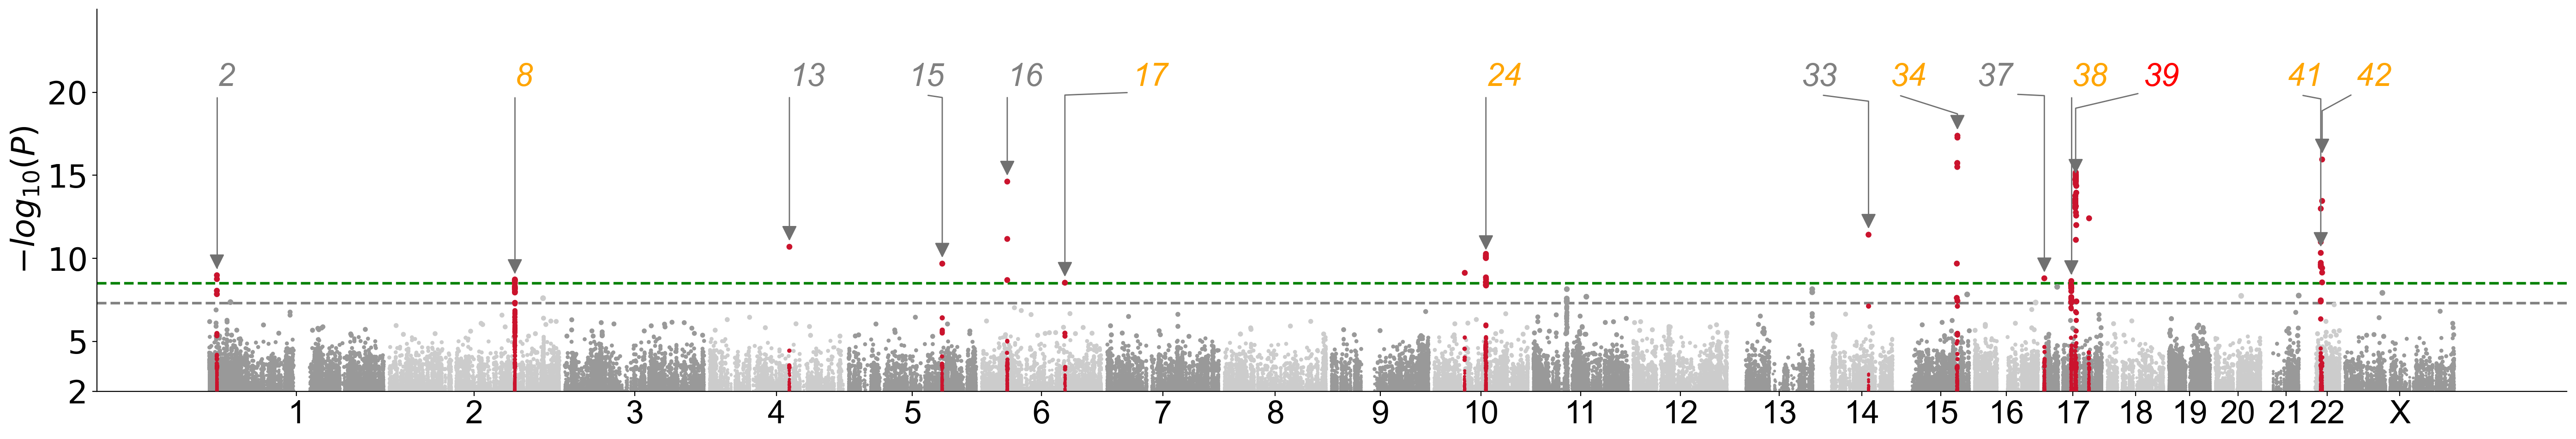

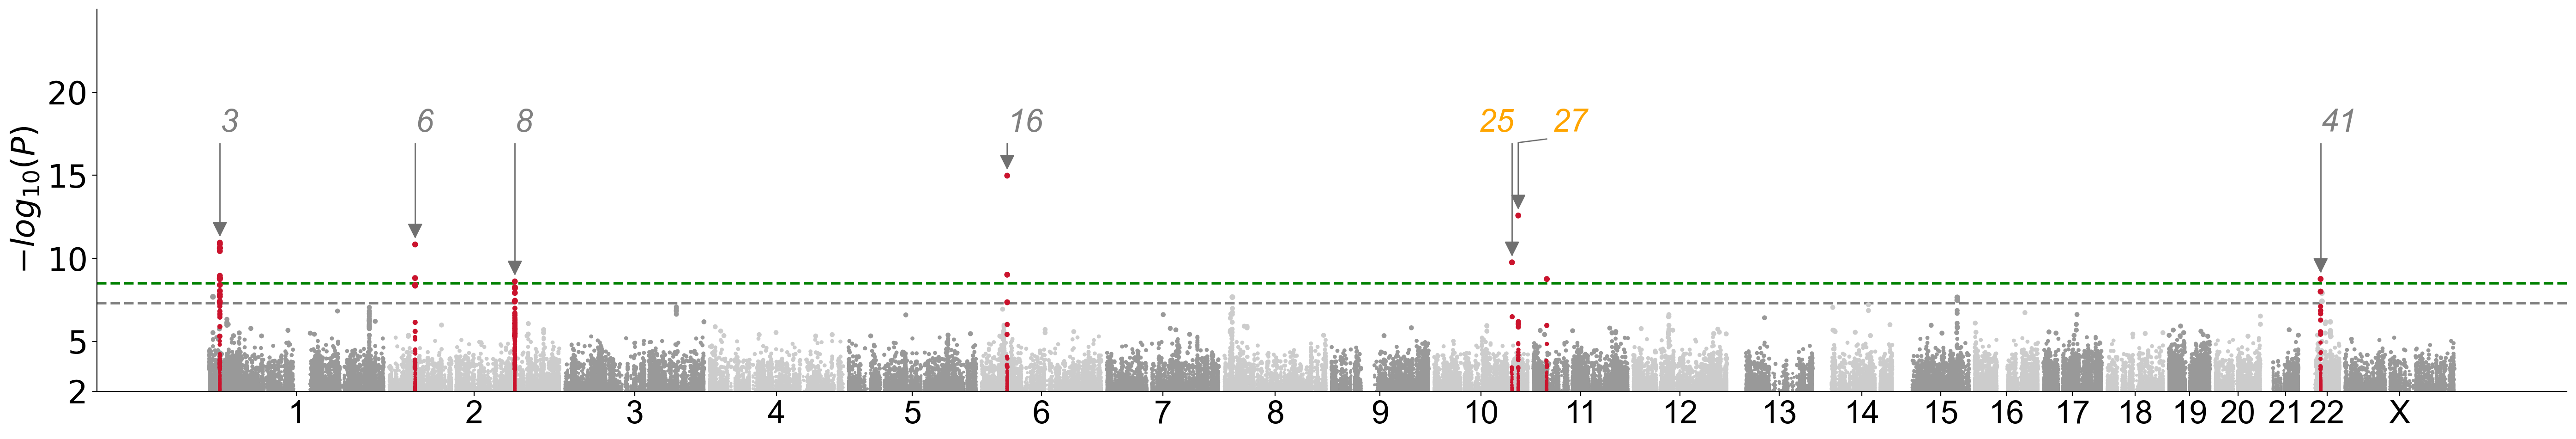

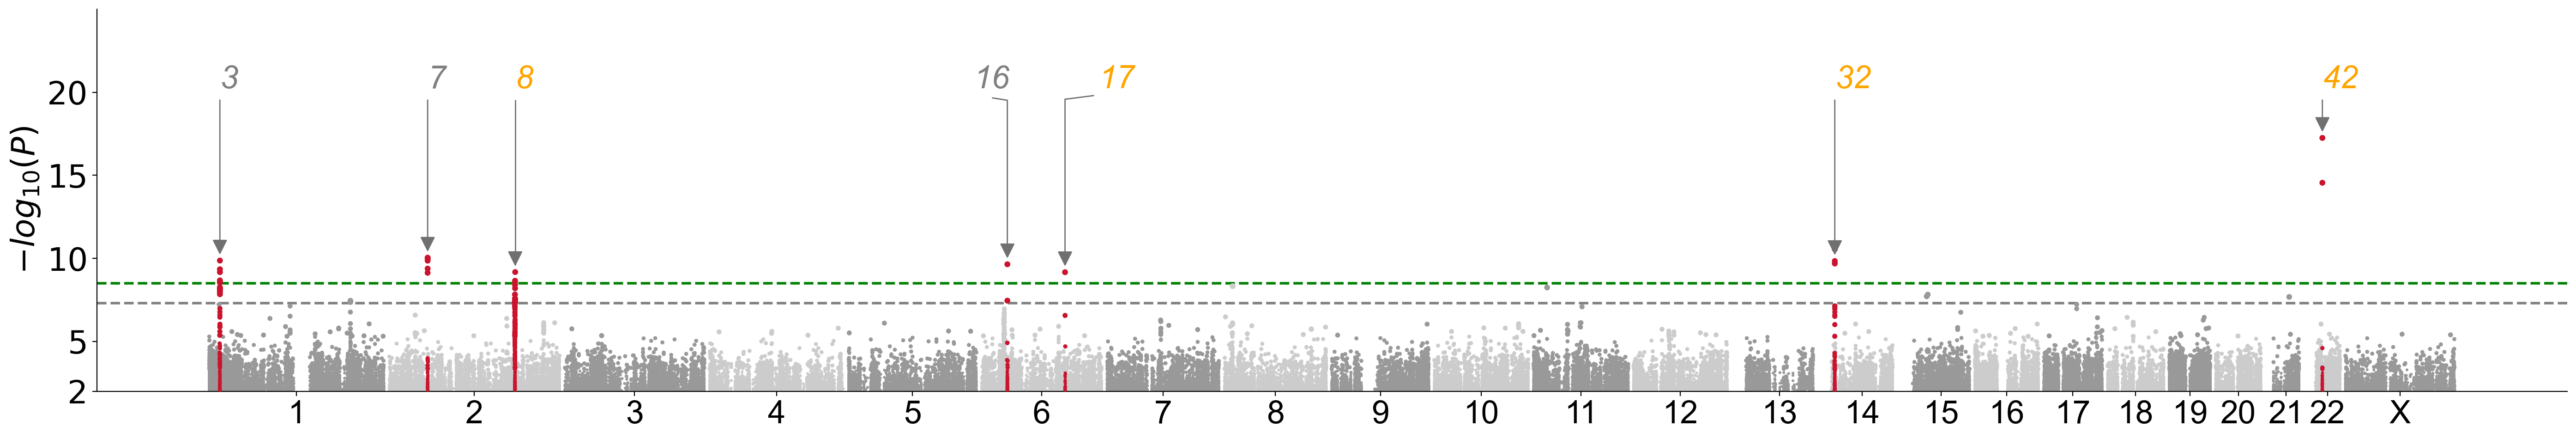

In [12]:
# manhattan plot for WT, Ecc, Err
exome_spatial_WT = get_mysumstats('/Volumes/acasis/cardiac/48K/exomeGWAS_aha_t64/AHA_exomeGWAS_{}_merged.SKIP2.regenie.gz'.format('WT'))
hits_WT = get_hits(exome_spatial_WT, vep_variants_tested)
hits_WT, gene_impact_WT, locus_impact_WT = add_locusID_to_hits(hits_WT, locus_all)
plot_exome_manhattan(exome_spatial_WT, hits_WT, locus_impact_WT, '/Users/clu/git/Spatial_LV_GWAS/Figures/source/manhattan/exomeGWAS_WT.manhattan.png')

# Similarly: exome_spatial_Ecc, hits_Ecc, gene_impact_Ecc, locus_impact_Ecc; exome_spatial_Err, hits_Err, gene_impact_Err, locus_impact_Err
exome_spatial_Ecc = get_mysumstats('/Volumes/acasis/cardiac/48K/exomeGWAS_aha_t64/AHA_exomeGWAS_{}_merged.SKIP2.regenie.gz'.format('Ecc'))
# reverse BETA
exome_spatial_Ecc.data['BETA'] = -exome_spatial_Ecc.data['BETA']
hits_Ecc = get_hits(exome_spatial_Ecc, vep_variants_tested)
hits_Ecc, gene_impact_Ecc, locus_impact_Ecc = add_locusID_to_hits(hits_Ecc, locus_all)
plot_exome_manhattan(exome_spatial_Ecc, hits_Ecc, locus_impact_Ecc, '/Users/clu/git/Spatial_LV_GWAS/Figures/source/manhattan/exomeGWAS_Ecc.manhattan.png')

# Err
exome_spatial_Err = get_mysumstats('/Volumes/acasis/cardiac/48K/exomeGWAS_aha_t64/AHA_exomeGWAS_{}_merged.SKIP2.regenie.gz'.format('Err'))
hits_Err = get_hits(exome_spatial_Err, vep_variants_tested)
hits_Err, gene_impact_Err, locus_impact_Err = add_locusID_to_hits(hits_Err, locus_all)
plot_exome_manhattan(exome_spatial_Err, hits_Err, locus_impact_Err, '/Users/clu/git/Spatial_LV_GWAS/Figures/source/manhattan/exomeGWAS_Err.manhattan.png')

In [105]:
# table of locus_impact_WT, locus_impact_Ecc, locus_impact_Err
gene_impact_WT['trait'] = 'WT'
gene_impact_Ecc['trait'] = 'Ecc'
gene_impact_Err['trait'] = 'Err'
gene_impact_all = pd.concat([gene_impact_WT, gene_impact_Ecc, gene_impact_Err], axis=0)

# table of locus_impact_WT, locus_impact_Ecc, locus_impact_Err
hits_WT['trait'] = 'WT'
hits_Ecc['trait'] = 'Ecc'
hits_Err['trait'] = 'Err'
hits_all = pd.concat([hits_WT, hits_Ecc, hits_Err], axis=0)
# define the order of IMPACT
hits_all['trait'] = pd.Categorical(hits_all['trait'], categories=['WT', 'Ecc', 'Err'])

print(gene_impact_all.columns)
print(hits_all.columns)

Spatial-only locus genes:


,SNPID,MLOG10P,gene_symbol_new,IMPACT,most_severe_consequence,gene_symbol,GenomicLocus,trait
15,17:39657827:G:A,8.63379,STARD3,MODERATE,missense_variant,STARD3,38,WT
17,6:118566140:T:C,8.53174,"CEP85L,PLN",MODERATE,missense_variant,"CEP85L, PLN, Z99496.1",17,WT
24,1:11816605:G:A,8.98225,CLCN6,MODIFIER,intron_variant,CLCN6,2,WT
30,14:71588751:A:C,11.42470,SIPA1L1,LOW,synonymous_variant,"AC004974.1, SIPA1L1",33,WT
31,4:113508251:C:T,10.69660,CAMK2D,LOW,synonymous_variant,CAMK2D,13,WT
32,5:133091159:GTT:G,9.68125,HSPA4,LOW,splice_region_variant,HSPA4,15,WT
6,2:37007376:T:C,10.83660,HEATR5B,MODIFIER,intron_variant,HEATR5B,6,Ecc
7,2:36883902:T:A,8.81146,STRN,MODIFIER,intron_variant,STRN,6,Ecc
1,14:23392602:A:G,9.83788,"MIR208A,MYH6",MODERATE,missense_variant,"MIR208A, MYH6",32,Err
3,6:118566140:T:C,9.16576,"CEP85L,PLN",MODERATE,missense_variant,"CEP85L, PLN, Z99496.1",17,Err


# Gene specific forest plots

In [5]:
# generic function to plot genes
def plot_gene(bigtrait, genename, lookup, sel_traits_names):
    # heatmap of beta values, and LOG10P values
    fig, ax = plt.subplots(2,1,figsize=(12,12))
    # font Arial
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.rcParams.update({'font.size': 12})
    # cmap is blue to red for beta values (middle 0, vmax = abs(beta)), and Reds for log10p values 
    betamax = abs(lookup[[f'{i}_BETA' for i in sel_traits]].values.flatten()).max()+0.01
    sns.heatmap(lookup[[f'{i}_BETA' for i in sel_traits]], center=0, ax=ax[0], cmap='RdBu_r', vmax=betamax, vmin=-betamax)
    sns.heatmap(lookup[[f'{i}_MLOG10P' for i in sel_traits]], ax=ax[1], cmap='Reds', vmax=20, vmin=0)
    # set xticklabels
    ax[0].set_xticklabels(sel_traits_names, rotation=45)
    ax[1].set_xticklabels(sel_traits_names, rotation=45)
    # # set y tick labels
    ax[0].set_yticklabels(lookup['label'], rotation=0)
    ax[1].set_yticklabels(lookup['label'], rotation=0)
    # set title
    ax[0].set_title('Beta values')
    ax[1].set_title('Log10P values')
    # hlines 
    for i in range(1, len(sel_traits)):
        ax[0].axvline(i, color='white', lw=0.5)
        ax[1].axvline(i, color='white', lw=0.5)
    for i in range(lookup.shape[0]):
        ax[0].axhline(i, color='white', lw=0.5)
        ax[1].axhline(i, color='white', lw=0.5)
    plt.tight_layout()
    # save
    plt.savefig(f'/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/Genes/exomeGWAS_{genename}_{bigtrait}_heatmapBetaLog10P.pdf')

    # forest plot of beta values
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    # for a selected variant: gene_symbol_new, highest IMPACT 
    lookup['IMPACT'] = pd.Categorical(lookup['IMPACT'], categories=['HIGH', 'MODERATE', 'LOW', 'MODIFIER'])
    sel_variant = lookup.sort_values(['IMPACT'], ascending=True).iloc[0]
    # forest plot each beta and se as error bar for the selected variant by sel_traits
    for i, trait in enumerate(sel_traits):
        # color by LOG10P
        ax.errorbar(sel_variant[f'{trait}_BETA'], i, xerr=sel_variant[f'{trait}_SE'], fmt='o', label=sel_traits_names[i], color=plt.cm.Reds(sel_variant[f'{trait}_MLOG10P']/20))
        # if LOG10P > -np.log10(5e-8/16) then annotate *
        if sel_variant[f'{trait}_MLOG10P'] > -np.log10(5e-8/16):
            ax.annotate('**', (sel_variant[f'{trait}_BETA'], i), fontsize=20, color='black', ha='center', va='center')
        elif sel_variant[f'{trait}_MLOG10P'] > -np.log10(5e-8):
            ax.annotate('*', (sel_variant[f'{trait}_BETA'], i), fontsize=20, color='black', ha='center', va='center')
    # add colorbar
    cmap = mpl.cm.ScalarMappable(cmap='Reds', norm=mpl.colors.Normalize(vmin=0, vmax=20))
    cbar = plt.colorbar(cmap, ax=ax, orientation='vertical', 
                        pad=0.1, aspect=10, shrink=0.6, 
                        label='-log10(P)', ticks=[0, 5, 10, 15, 20])
    _ = ax.set_yticks(range(len(sel_traits)))
    _ = ax.set_yticklabels(sel_traits_names)
    ax.set_xlim(-betamax, betamax)
    ax.set_xlabel('Beta (SE)')
    ax.grid(axis='x', linestyle='--')
    # vertical line at 0
    ax.axvline(0, color='black', lw=0.5, linestyle='--')
    # set title
    ax.set_title(f'{sel_variant.gene_symbol_new} - {sel_variant.SNPID} ({sel_variant.most_severe_consequence}, EAF:{sel_variant.EAF:.2f})')
    plt.tight_layout()
    # save
    plt.savefig(f'/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/Genes/exomeGWAS_{genename}_{bigtrait}_forestplotBeta.pdf')

    #### bullseye plot of beta values and -log10(p) values
    # Make a figure and axes with dimensions as desired.
    fig, axes = plt.subplots(figsize=(6, 4), nrows=1, ncols=2, subplot_kw=dict(projection='polar'))
    fig.canvas.manager.set_window_title('Left Ventricle Bulls Eyes (AHA)')

    # make dataframe to plot
    toplot_bullseye = pd.DataFrame({
        'traits': sel_traits_names[:17],
        'beta': [sel_variant[f'{trait}_BETA'] for trait in sel_traits[:17]],
        'log10p': [sel_variant[f'{trait}_MLOG10P'] for trait in sel_traits[:17]]
    }).set_index('traits')

    cmap = get_cmap_center('RdBu_r', center=0, vmin=-betamax, vmax=betamax)
    norm = mpl.colors.Normalize(vmin=-betamax, vmax=betamax)
    bullseye_plot(axes[0], toplot_bullseye['beta'], cmap=cmap, norm=norm)
    # # Create the axis for the colorbars
    # axl = fig.add_axes([0.2, 0.1, 0.2, 0.1])
    # fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    #             cax=axl, orientation='horizontal', label='Beta')

    cmap = get_cmap_center('Reds', vmin=0, vmax=20, center=10)
    norm = mpl.colors.Normalize(vmin=0, vmax=20)
    bullseye_plot(axes[1], toplot_bullseye['log10p'], cmap=cmap, norm=norm)
    # # Create the axis for the colorbars
    # axl = fig.add_axes([0.7, 0.1, 0.2, 0.1])
    # fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    #             cax=axl, orientation='horizontal', label='-log10(P)')
    # set title
    fig.suptitle(f'{sel_variant.gene_symbol_new} - {sel_variant.SNPID} ({sel_variant.most_severe_consequence}, EAF:{sel_variant.EAF:.2f})')
    plt.tight_layout()
    # save
    plt.savefig(f'/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/Genes/exomeGWAS_{genename}_{bigtrait}_bullseyeBetaLog10P.pdf')


def forrestplot_gene(bigtrait, genename, lookup, sel_traits, sel_traits_names):
    betamax = abs(lookup[[f'{i}_BETA' for i in sel_traits]].values.flatten()).max()+0.4
    # forest plot of beta values
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    # for a selected variant: gene_symbol_new, highest IMPACT 
    lookup['IMPACT'] = pd.Categorical(lookup['IMPACT'], categories=['HIGH', 'MODERATE', 'LOW', 'MODIFIER'])
    sel_variant = lookup.sort_values(['IMPACT'], ascending=True).iloc[0]
    # forest plot each beta and se as error bar for the selected variant by sel_traits
    for i, trait in enumerate(sel_traits):
        # color by LOG10P
        ax.errorbar(sel_variant[f'{trait}_BETA'], i, xerr=sel_variant[f'{trait}_SE'], fmt='o', label=sel_traits_names[i], color=plt.cm.Reds(sel_variant[f'{trait}_MLOG10P']/20))
        # if LOG10P > -np.log10(5e-8/16) then annotate *
        if sel_variant[f'{trait}_MLOG10P'] > -np.log10(5e-8/16):
            ax.annotate('**', (sel_variant[f'{trait}_BETA'], i), fontsize=20, color='black', ha='center', va='center')
        elif sel_variant[f'{trait}_MLOG10P'] > -np.log10(5e-8):
            ax.annotate('*', (sel_variant[f'{trait}_BETA'], i), fontsize=20, color='black', ha='center', va='center')
    # add colorbar
    cmap = mpl.cm.ScalarMappable(cmap='Reds', norm=mpl.colors.Normalize(vmin=0, vmax=20))
    cbar = plt.colorbar(cmap, ax=ax, orientation='vertical', 
                        pad=0.1, aspect=10, shrink=0.6, 
                        label='-log10(P)', ticks=[0, 5, 10, 15, 20])
    _ = ax.set_yticks(range(len(sel_traits)))
    _ = ax.set_yticklabels(sel_traits_names)
    ax.set_xlim(-betamax, betamax)
    ax.set_xlabel('Beta (SE)')
    ax.grid(axis='x', linestyle='--')
    # vertical line at 0
    ax.axvline(0, color='black', lw=0.5, linestyle='--')
    # set title
    ax.set_title(f'{sel_variant.gene_symbol_new} - {sel_variant.SNPID} ({sel_variant.most_severe_consequence}, EAF:{sel_variant.EAF:.5f})')
    plt.tight_layout()
    # save
    plt.savefig(f'/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/Genes/exomeGWAS_{genename}_{bigtrait}_forestplotBeta.pdf')

## WT

In [ ]:
# read the beta and p values for the hits for WT AHA segments
def filter_summstats(gwaspath, filtersnps):
    mysumstats = gl.Sumstats(gwaspath, fmt="regenie", verbose=False)
    # Exclude 90pct10dp failed variants
    mysumstats.data = mysumstats.data[mysumstats.data['SNPID'].isin(filtersnps)]
    return mysumstats.data

filter_snpids = set(hits_all[(hits_all.trait=='WT')].SNPID.tolist())
sel_traits = [f'WT_AHA_{i}' for i in range(1,17)] + ['WT_Global', 'WT_Max_Global', 'LVM']
sel_traits_names = [f'AHA {i}' for i in range(1,17)] + ['WT_G', 'WT_Max', 'LVM']

exome_spatial_WT = pd.DataFrame()
for it, trait in enumerate(sel_traits):
    print(trait, exome_spatial_WT.shape)
    eachone = filter_summstats(f'/Volumes/acasis/cardiac/48K/exomeGWAS_aha_t64/AHA_exomeGWAS_{trait}_chrmerged.regenie.gz', filter_snpids)
    eachone = eachone[[
        'SNPID', 'BETA', 'MLOG10P', 'SE'
    ]].rename(columns={
        'BETA': f'{trait}_BETA',
        'MLOG10P': f'{trait}_MLOG10P',
        'SE': f'{trait}_SE'
    })
    if it == 0:
        exome_spatial_WT = eachone
    else:
        exome_spatial_WT = pd.merge(exome_spatial_WT, eachone, on='SNPID', how='left')
    

In [4]:
def plot_gene(bigtrait, genename, lookup, sel_traits_names):
    # heatmap of beta values, and LOG10P values
    fig, ax = plt.subplots(2,1,figsize=(12,12))
    # font Arial
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.rcParams.update({'font.size': 12})
    # cmap is blue to red for beta values (middle 0, vmax = abs(beta)), and Reds for log10p values 
    betamax = abs(lookup[[f'{i}_BETA' for i in sel_traits]].values.flatten()).max()+0.01
    sns.heatmap(lookup[[f'{i}_BETA' for i in sel_traits]], center=0, ax=ax[0], cmap='RdBu_r', vmax=betamax, vmin=-betamax)
    sns.heatmap(lookup[[f'{i}_MLOG10P' for i in sel_traits]], ax=ax[1], cmap='Reds', vmax=20, vmin=0)
    # set xticklabels
    ax[0].set_xticklabels(sel_traits_names, rotation=45)
    ax[1].set_xticklabels(sel_traits_names, rotation=45)
    # # set y tick labels
    ax[0].set_yticklabels(lookup['label'], rotation=0)
    ax[1].set_yticklabels(lookup['label'], rotation=0)
    # set title
    ax[0].set_title('Beta values')
    ax[1].set_title('Log10P values')
    # hlines 
    for i in range(1, len(sel_traits)):
        ax[0].axvline(i, color='white', lw=0.5)
        ax[1].axvline(i, color='white', lw=0.5)
    for i in range(lookup.shape[0]):
        ax[0].axhline(i, color='white', lw=0.5)
        ax[1].axhline(i, color='white', lw=0.5)
    plt.tight_layout()
    # save
    plt.savefig(f'/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/Genes/exomeGWAS_{genename}_{bigtrait}_heatmapBetaLog10P.pdf')

    # forest plot of beta values
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    # for a selected variant: gene_symbol_new, highest IMPACT 
    lookup['IMPACT'] = pd.Categorical(lookup['IMPACT'], categories=['HIGH', 'MODERATE', 'LOW', 'MODIFIER'])
    sel_variant = lookup.sort_values(['IMPACT'], ascending=True).iloc[0]
    # forest plot each beta and se as error bar for the selected variant by sel_traits
    for i, trait in enumerate(sel_traits):
        # color by LOG10P
        ax.errorbar(sel_variant[f'{trait}_BETA'], i, xerr=sel_variant[f'{trait}_SE'], fmt='o', label=sel_traits_names[i], color=plt.cm.Reds(sel_variant[f'{trait}_MLOG10P']/20))
        # if LOG10P > -np.log10(5e-8/16) then annotate *
        if sel_variant[f'{trait}_MLOG10P'] > -np.log10(5e-8/16):
            ax.annotate('**', (sel_variant[f'{trait}_BETA'], i), fontsize=20, color='black', ha='center', va='center')
        elif sel_variant[f'{trait}_MLOG10P'] > -np.log10(5e-8):
            ax.annotate('*', (sel_variant[f'{trait}_BETA'], i), fontsize=20, color='black', ha='center', va='center')
    # add colorbar
    cmap = mpl.cm.ScalarMappable(cmap='Reds', norm=mpl.colors.Normalize(vmin=0, vmax=20))
    cbar = plt.colorbar(cmap, ax=ax, orientation='vertical', 
                        pad=0.1, aspect=10, shrink=0.6, 
                        label='-log10(P)', ticks=[0, 5, 10, 15, 20])
    _ = ax.set_yticks(range(len(sel_traits)))
    _ = ax.set_yticklabels(sel_traits_names)
    ax.set_xlim(-betamax, betamax)
    ax.set_xlabel('Beta (SE)')
    ax.grid(axis='x', linestyle='--')
    # vertical line at 0
    ax.axvline(0, color='black', lw=0.5, linestyle='--')
    # set title
    ax.set_title(f'{sel_variant.gene_symbol_new} - {sel_variant.SNPID} ({sel_variant.most_severe_consequence}, EAF:{sel_variant.EAF:.2f})')
    plt.tight_layout()
    # save
    plt.savefig(f'/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/Genes/exomeGWAS_{genename}_{bigtrait}_forestplotBeta.pdf')

    #### bullseye plot of beta values and -log10(p) values
    # Make a figure and axes with dimensions as desired.
    fig, axes = plt.subplots(figsize=(6, 4), nrows=1, ncols=2, subplot_kw=dict(projection='polar'))
    fig.canvas.manager.set_window_title('Left Ventricle Bulls Eyes (AHA)')

    # make dataframe to plot
    toplot_bullseye = pd.DataFrame({
        'traits': sel_traits_names[:17],
        'beta': [sel_variant[f'{trait}_BETA'] for trait in sel_traits[:17]],
        'log10p': [sel_variant[f'{trait}_MLOG10P'] for trait in sel_traits[:17]]
    }).set_index('traits')

    cmap = get_cmap_center('RdBu_r', center=0, vmin=-betamax, vmax=betamax)
    norm = mpl.colors.Normalize(vmin=-betamax, vmax=betamax)
    bullseye_plot(axes[0], toplot_bullseye['beta'], cmap=cmap, norm=norm)
    # Create the axis for the colorbars
    axl = fig.add_axes([0.2, 0.1, 0.2, 0.1])
    fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
                cax=axl, orientation='horizontal', label='Beta')

    cmap = get_cmap_center('Reds', vmin=0, vmax=20, center=10)
    norm = mpl.colors.Normalize(vmin=0, vmax=20)
    bullseye_plot(axes[1], toplot_bullseye['log10p'], cmap=cmap, norm=norm)
    # Create the axis for the colorbars
    axl = fig.add_axes([0.7, 0.1, 0.2, 0.1])
    fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
                cax=axl, orientation='horizontal', label='-log10(P)')
    # set title
    fig.suptitle(f'{sel_variant.gene_symbol_new} - {sel_variant.SNPID} ({sel_variant.most_severe_consequence}, EAF:{sel_variant.EAF:.2f})')
    plt.tight_layout()
    # save
    plt.savefig(f'/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/Genes/exomeGWAS_{genename}_{bigtrait}_bullseyeBetaLog10P.pdf')


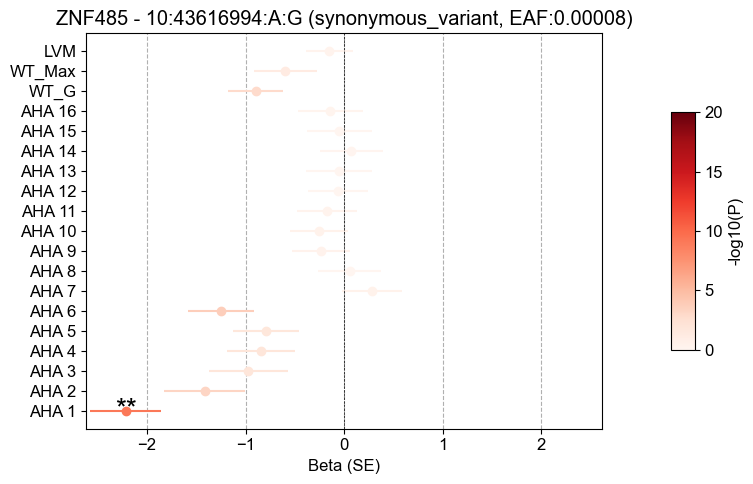

In [160]:
# forest plot for special large beta gene
bigtrait = 'WT'
genename = 'ZNF485'

sel_traits_names = [f'AHA {i}' for i in range(1,17)] + ['WT_G', 'WT_Max', 'LVM']

lookup = hits_all[(hits_all.trait==bigtrait) & (hits_all.gene_symbol_new.str.contains(genename))
                ][['Spatial_Only', 'impact_level', 'trait', 'GenomicLocus',
    'gene_symbol_new', 'SNPID', 'IMPACT', 'most_severe_consequence', 'EAF']].copy()
lookup = lookup.merge(exome_spatial_WT, on='SNPID', how='left')
lookup = lookup.assign(label = lookup.apply(lambda x: f'{x.gene_symbol_new} {x.SNPID}({x.most_severe_consequence}, {x.EAF})', axis=1))


def forrestplot_gene(genename, lookup, sel_traits_names):
    betamax = abs(lookup[[f'{i}_BETA' for i in sel_traits]].values.flatten()).max()+0.4
    # forest plot of beta values
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    # for a selected variant: gene_symbol_new, highest IMPACT 
    lookup['IMPACT'] = pd.Categorical(lookup['IMPACT'], categories=['HIGH', 'MODERATE', 'LOW', 'MODIFIER'])
    sel_variant = lookup.sort_values(['IMPACT'], ascending=True).iloc[0]
    # forest plot each beta and se as error bar for the selected variant by sel_traits
    for i, trait in enumerate(sel_traits):
        # color by LOG10P
        ax.errorbar(sel_variant[f'{trait}_BETA'], i, xerr=sel_variant[f'{trait}_SE'], fmt='o', label=sel_traits_names[i], color=plt.cm.Reds(sel_variant[f'{trait}_MLOG10P']/20))
        # if LOG10P > -np.log10(5e-8/16) then annotate *
        if sel_variant[f'{trait}_MLOG10P'] > -np.log10(5e-8/16):
            ax.annotate('**', (sel_variant[f'{trait}_BETA'], i), fontsize=20, color='black', ha='center', va='center')
        elif sel_variant[f'{trait}_MLOG10P'] > -np.log10(5e-8):
            ax.annotate('*', (sel_variant[f'{trait}_BETA'], i), fontsize=20, color='black', ha='center', va='center')
    # add colorbar
    cmap = mpl.cm.ScalarMappable(cmap='Reds', norm=mpl.colors.Normalize(vmin=0, vmax=20))
    cbar = plt.colorbar(cmap, ax=ax, orientation='vertical', 
                        pad=0.1, aspect=10, shrink=0.6, 
                        label='-log10(P)', ticks=[0, 5, 10, 15, 20])
    _ = ax.set_yticks(range(len(sel_traits)))
    _ = ax.set_yticklabels(sel_traits_names)
    ax.set_xlim(-betamax, betamax)
    ax.set_xlabel('Beta (SE)')
    ax.grid(axis='x', linestyle='--')
    # vertical line at 0
    ax.axvline(0, color='black', lw=0.5, linestyle='--')
    # set title
    ax.set_title(f'{sel_variant.gene_symbol_new} - {sel_variant.SNPID} ({sel_variant.most_severe_consequence}, EAF:{sel_variant.EAF:.5f})')
    plt.tight_layout()
    # save
    plt.savefig(f'/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/Genes/exomeGWAS_{genename}_{bigtrait}_forestplotBeta.pdf')

forrestplot_gene(genename, lookup, sel_traits_names)

## Ecc

In [ ]:
# read the beta and p values for the hits for WT AHA segments
def filter_summstats(gwaspath, filtersnps):
    mysumstats = gl.Sumstats(gwaspath, fmt="regenie", verbose=False)
    # Exclude 90pct10dp failed variants
    mysumstats.data = mysumstats.data[mysumstats.data['SNPID'].isin(filtersnps)]
    return mysumstats.data

filter_snpids = set(hits_all[(hits_all.trait=='Ecc')].SNPID.tolist())
sel_traits = [f'Ecc_AHA_{i}' for i in range(1,17)] + ['Ecc_Global', 'LVEF', 'LVM']
sel_traits_names = [f'AHA {i}' for i in range(1,17)] + ['Ecc_G', 'LVEF', 'LVM']

exome_spatials = pd.DataFrame()
for it, trait in enumerate(sel_traits):
    print(trait, exome_spatials.shape)
    eachone = filter_summstats(f'/Volumes/acasis/cardiac/48K/exomeGWAS_aha_t64/AHA_exomeGWAS_{trait}_chrmerged.regenie.gz', filter_snpids)
    eachone = eachone[[
        'SNPID', 'BETA', 'MLOG10P', 'SE'
    ]]
    # JUST FOR ECC
    if 'Ecc' in trait:
        eachone['BETA'] = -eachone['BETA']
    eachone = eachone.rename(columns={
        'BETA': f'{trait}_BETA',
        'MLOG10P': f'{trait}_MLOG10P',
        'SE': f'{trait}_SE'
    })
    if it == 0:
        exome_spatials = eachone
    else:
        exome_spatials = pd.merge(exome_spatials, eachone, on='SNPID', how='left')
    

In [ ]:
#  plot individual genes
for genename in ['CLCNKA','HSPB7','HEATR5B','STRN','TTN',
'CDKN1A','RBM20','BAG3','DERL3,SMARCB1','CSRP3']:
    sel_traits_names = [f'AHA {i}' for i in range(1,17)] + ['Ecc_G', 'LVEF', 'LVM']

    lookup = hits_all[(hits_all.trait==bigtrait) & (hits_all.gene_symbol_new.str.contains(genename))
                    ][['Spatial_Only', 'impact_level', 'trait', 'GenomicLocus',
        'gene_symbol_new', 'SNPID', 'IMPACT', 'most_severe_consequence', 'EAF']].copy()
    lookup = lookup.merge(exome_spatials, on='SNPID', how='left')
    lookup = lookup.assign(label = lookup.apply(lambda x: f'{x.gene_symbol_new} {x.SNPID}({x.most_severe_consequence}, {x.EAF})', axis=1))

    # JUMP IF NO HITS
    if lookup.shape[0] == 0:
        print('No hits for', genename)
        continue

    plot_gene(bigtrait, genename, lookup, sel_traits_names)


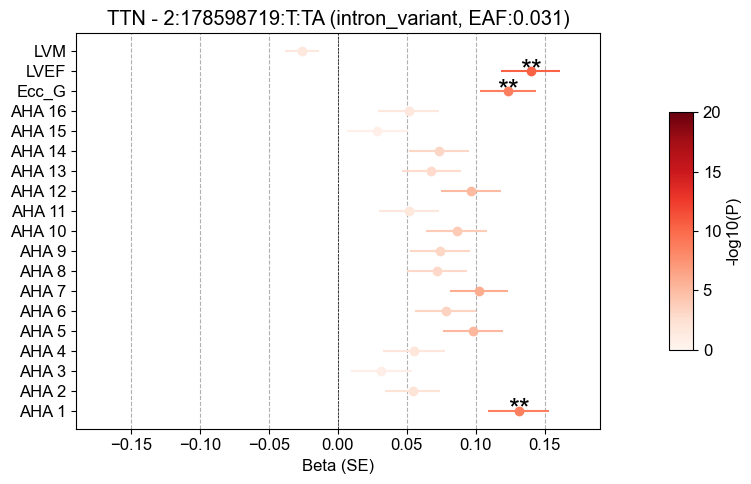

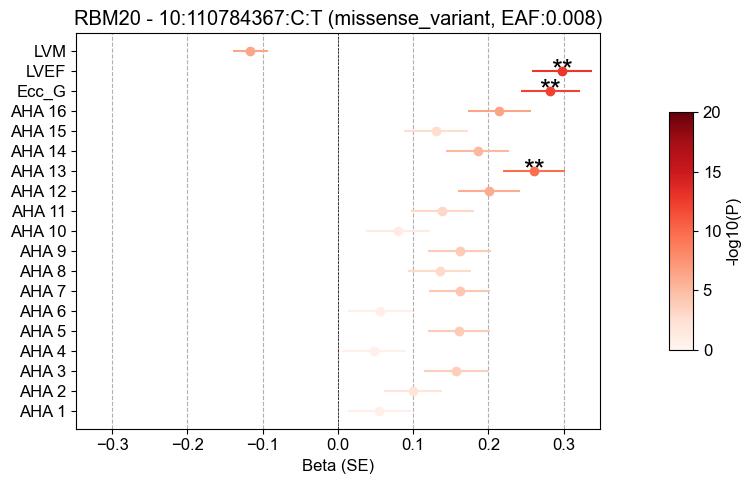

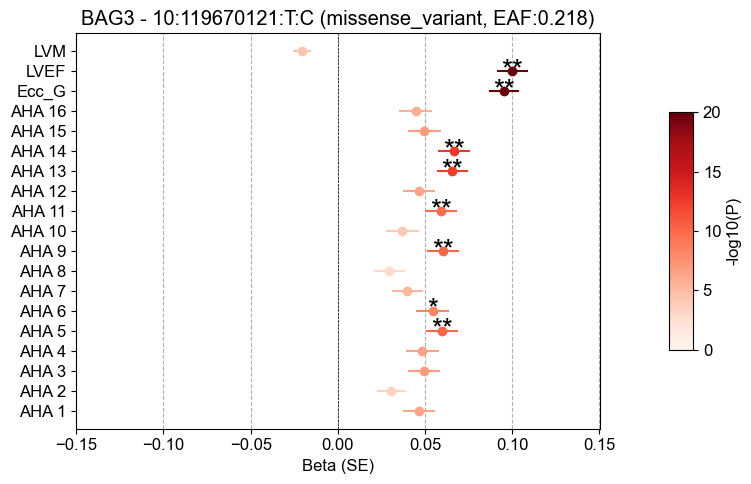

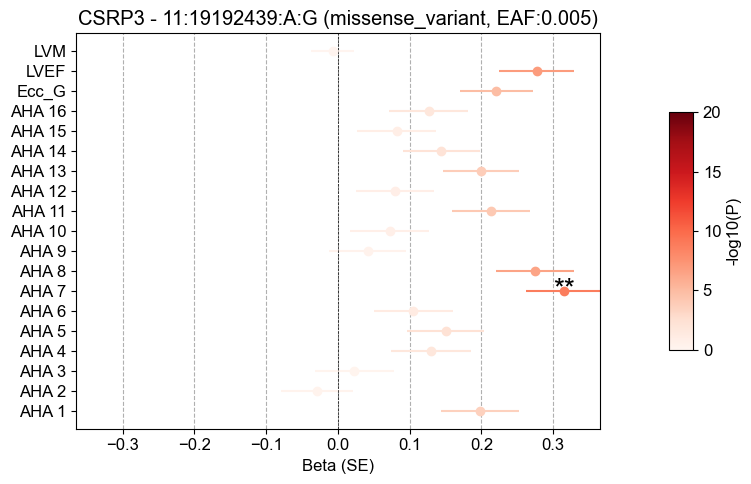

In [14]:
# special large beta gene

def forrestplot_gene(bigtrait, genename, lookup, sel_traits, sel_traits_names):
    betamax = abs(lookup[[f'{i}_BETA' for i in sel_traits]].values.flatten()).max()+0.05
    # forest plot of beta values
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    # for a selected variant: gene_symbol_new, highest IMPACT 
    lookup['IMPACT'] = pd.Categorical(lookup['IMPACT'], categories=['HIGH', 'MODERATE', 'LOW', 'MODIFIER'])
    sel_variant = lookup.sort_values(['IMPACT'], ascending=True).iloc[0]
    # forest plot each beta and se as error bar for the selected variant by sel_traits
    for i, trait in enumerate(sel_traits):
        # color by LOG10P
        ax.errorbar(sel_variant[f'{trait}_BETA'], i, xerr=sel_variant[f'{trait}_SE'], fmt='o', label=sel_traits_names[i], color=plt.cm.Reds(sel_variant[f'{trait}_MLOG10P']/20))
        # if LOG10P > -np.log10(5e-8/16) then annotate *
        if sel_variant[f'{trait}_MLOG10P'] > -np.log10(5e-8/16):
            ax.annotate('**', (sel_variant[f'{trait}_BETA'], i), fontsize=20, color='black', ha='center', va='center')
        elif sel_variant[f'{trait}_MLOG10P'] > -np.log10(5e-8):
            ax.annotate('*', (sel_variant[f'{trait}_BETA'], i), fontsize=20, color='black', ha='center', va='center')
    # add colorbar
    cmap = mpl.cm.ScalarMappable(cmap='Reds', norm=mpl.colors.Normalize(vmin=0, vmax=20))
    cbar = plt.colorbar(cmap, ax=ax, orientation='vertical', 
                        pad=0.1, aspect=10, shrink=0.6, 
                        label='-log10(P)', ticks=[0, 5, 10, 15, 20])
    _ = ax.set_yticks(range(len(sel_traits)))
    _ = ax.set_yticklabels(sel_traits_names)
    ax.set_xlim(-betamax, betamax)
    ax.set_xlabel('Beta (SE)')
    ax.grid(axis='x', linestyle='--')
    # vertical line at 0
    ax.axvline(0, color='black', lw=0.5, linestyle='--')
    # set title
    ax.set_title(f'{sel_variant.gene_symbol_new} - {sel_variant.SNPID} ({sel_variant.most_severe_consequence}, EAF:{sel_variant.EAF:.3f})')
    plt.tight_layout()
    # save
    plt.savefig(f'/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/Genes/exomeGWAS_{genename}_{bigtrait}_forestplotBeta.pdf')

for genename in ['TTN','RBM20','BAG3','CSRP3']:
    sel_traits_names = [f'AHA {i}' for i in range(1,17)] + ['Ecc_G', 'LVEF', 'LVM']

    lookup = hits_all[(hits_all.trait==bigtrait) & (hits_all.gene_symbol_new.str.contains(genename))
                    ][['Spatial_Only', 'impact_level', 'trait', 'GenomicLocus',
        'gene_symbol_new', 'SNPID', 'IMPACT', 'most_severe_consequence', 'EAF']].copy()
    lookup = lookup.merge(exome_spatials, on='SNPID', how='left')
    lookup = lookup.assign(label = lookup.apply(lambda x: f'{x.gene_symbol_new} {x.SNPID}({x.most_severe_consequence}, {x.EAF})', axis=1))

    # JUMP IF NO HITS
    if lookup.shape[0] == 0:
        print('No hits for', genename)
        continue
    forrestplot_gene(bigtrait, genename, lookup, sel_traits, sel_traits_names)

## Err

In [ ]:
#  plot individual genes
for genename in ['CLCNKA','HSPB7','SPTBN1','CCDC141','TTN',
'CDKN1A','PLN','MYH6','MYO18B']:
    sel_traits_names = [f'AHA {i}' for i in range(1,17)] + ['Err_G', 'LVEF', 'LVM']

    lookup = hits_all[(hits_all.trait==bigtrait) & (hits_all.gene_symbol_new.str.contains(genename))
                    ][['Spatial_Only', 'impact_level', 'trait', 'GenomicLocus',
        'gene_symbol_new', 'SNPID', 'IMPACT', 'most_severe_consequence', 'EAF']].copy()
    lookup = lookup.merge(exome_spatials, on='SNPID', how='left')
    lookup = lookup.assign(label = lookup.apply(lambda x: f'{x.gene_symbol_new} {x.SNPID}({x.most_severe_consequence}, {x.EAF})', axis=1))

    # JUMP IF NO HITS
    if lookup.shape[0] == 0:
        print('No hits for', genename)
        continue

    plot_gene(bigtrait, genename, lookup, sel_traits_names)
